# Deep Learning Project : Brain Tumor Semantic Segmentation
### Eman Said Al-Hajri
### AI and Data Science Stream

- The project aims to identify tumor regions accurately in Brain within Medical Images using advanced techniques. 

- Classes:

   *  Tumor (Class 1)
   *  Non-Tumor (Class 0)

- Reference: https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation/data

--------------

### 1. Load Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import skimage.io
import random
import cv2

/home/iman/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### 2. Load Dataset 

In [2]:
train_path  = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/train/'
test_path = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/test/'
val_path  = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/valid/'

In [3]:
train_images = [image for image in os.listdir(train_path) if image[-3:] =='jpg' ]
test_images = [image for image in os.listdir(test_path) if image[-3:] =='jpg' ]
val_images = [image for image in os.listdir(val_path) if image[-3:] =='jpg' ]
len(train_images),len(test_images),len(val_images)

(1502, 215, 429)

In [5]:
img = cv2.imread("/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/train/2_jpg.rf.fded76c07e967829600f3509288fdfe0.jpg")
img.shape


(640, 640, 3)

In [6]:
trainMask_path  = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/train_masks/'
testMask_path = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/test_masks/'
valMask_path  = '/home/iman/Desktop/Makeen-AI/DL/DL-Project/Brain_Tumor/val_masks/'

In [7]:
train_masks = [image for image in os.listdir(trainMask_path) if image[-3:] =='jpg' ]
test_masks = [image for image in os.listdir(testMask_path) if image[-3:] =='jpg' ]
val_masks = [image for image in os.listdir(valMask_path) if image[-3:] =='jpg' ]
len(train_masks),len(test_masks),len(val_masks)

(1502, 215, 429)

### 3. Explore and Preprocess the Data

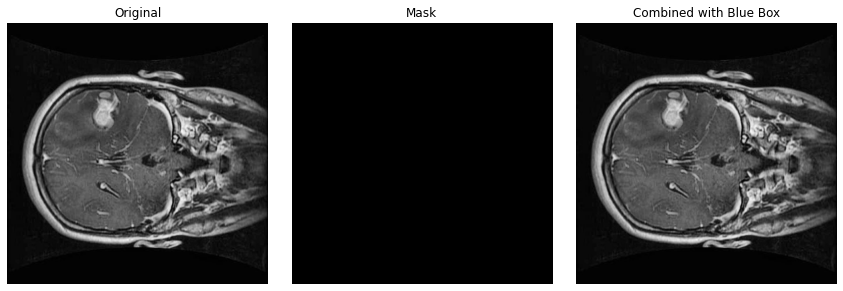

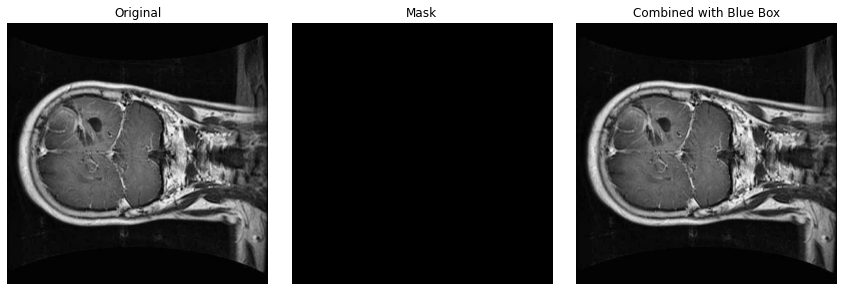

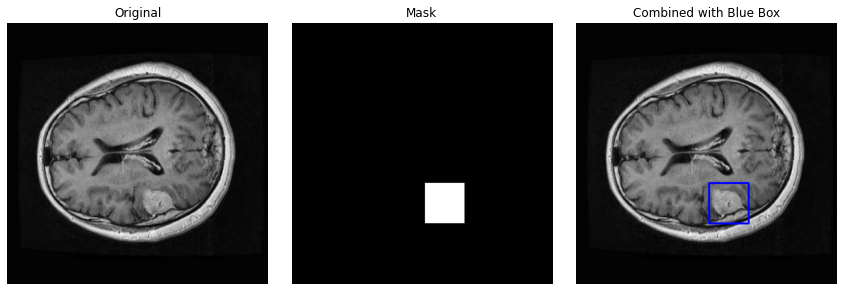

In [8]:
def display_random_images_with_masks_and_boxes(image_dir, mask_dir, num_samples=3):
    
    image_files = [img for img in os.listdir(image_dir) if img.endswith('.jpg')]
    mask_files = [img for img in os.listdir(mask_dir) if img.endswith('.jpg')]

    
    selected_images = random.sample(image_files, num_samples)

    for img_name in selected_images:
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)

        
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        
        if mask.shape != image.shape[:2]:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        
        _, binary_mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)

        
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        combined = image_rgb.copy()
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(combined, (x, y), (x + w, y + h), color=(0, 0, 255), thickness=3)  

        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image_rgb)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(combined)
        plt.title('Combined with Blue Box')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


display_random_images_with_masks_and_boxes(train_path, trainMask_path)


### 4. Split the Data

In [9]:
import cv2
import numpy as np
import os

def data_generator(image_list, mask_list, image_dir, mask_dir, batch_size=8, target_size=(512,512)):
    while True:  
        for start in range(0, len(image_list), batch_size):
            end = min(start + batch_size, len(image_list))
            batch_images = image_list[start:end]
            batch_masks = mask_list[start:end]

            X = []
            y = []
            for img_name, mask_name in zip(batch_images, batch_masks):
               
                img_path = os.path.join(image_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, target_size)
                img = img.astype(np.float32) / 255.0

               
                mask_path = os.path.join(mask_dir, mask_name)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, target_size)
                mask = mask.astype(np.float32) / 255.0
                mask = (mask > 0.5).astype(np.float32)
                mask = np.expand_dims(mask, axis=-1)  # add channel dim

                X.append(img)
                y.append(mask)

            yield np.array(X), np.array(y)


In [10]:
batch_size = 8
train_gen = data_generator(train_images, train_masks, train_path, trainMask_path, batch_size)
val_gen = data_generator(val_images, val_masks, val_path, valMask_path, batch_size)
test_gen = data_generator(test_images, test_masks, test_path, testMask_path, batch_size)

X_batch, y_batch = next(train_gen)
print(X_batch.shape, y_batch.shape)


(8, 512, 512, 3) (8, 512, 512, 1)


### 5. Define the Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, filters):
    x = layers.Conv2DTranspose(filters, kernel_size=(2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, filters)
    return x

def build_model(input_shape=(512, 512, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(num_classes, kernel_size=(1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs, outputs)
    return model


In [12]:
model = build_model(input_shape=(512, 512, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_16 (Conv2D)             (None, 512, 512, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_16[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 512, 512, 1)  65          ['conv2d_17[0][0]']              
                                                                                                  
Total params: 31,031,745
Trainable params: 31,031,745
Non-trainable params: 0
_______________________________

In [13]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss


### 6. Compile the Model

In [14]:
model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=['accuracy', dice_coefficient])


### 7. Train the Model

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_images) // batch_size,
    epochs=20
)

Epoch 1/20


2025-07-05 22:19:19.665802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-07-05 22:19:55.331767: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.
2025-07-05 22:20:11.769492: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1207959552 exceeds 10% of free system memory.
2025-07-05 22:20:11.772655: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.
2025-07-05 22:20:11.772747: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1207959552 exceeds 10% of free system memory.


  1/187 [..............................] - ETA: 7:46:17 - loss: 0.9888 - accuracy: 0.9940 - dice_coefficient: 0.0112

2025-07-05 22:22:23.595939: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1073741824 exceeds 10% of free system memory.


### 8. Predict and Evaluate the Model

In [ ]:
X_test_batches = []
y_test_batches = []

for i in range(len(test_images) // batch_size):
    X_batch, y_batch = next(test_gen)
    X_test_batches.append(X_batch)
    y_test_batches.append(y_batch)

X_test = np.concatenate(X_test_batches, axis=0)
y_test = np.concatenate(y_test_batches, axis=0)

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.float32)

dice = dice_coefficient(tf.convert_to_tensor(y_test), tf.convert_to_tensor(y_pred))
print("Dice Coefficient:", dice.numpy())


### 9. Fine-Tune and Optimize

### 10. Make Predictions

### 11. Evaluate the Model and Visualize Results (Metrics/Predictions)

### 12. Save and Load the Model